In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from neuropacks import NHP
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

In [3]:
data_paths = np.sort(os.listdir('/storage/data/nhp')).tolist()

In [4]:
nhp = NHP(data_path='/storage/data/nhp/' + data_paths[9])

In [5]:
dt = 0.25

In [6]:
Y = nhp.get_response_matrix(bin_width=dt, region='M1', transform='square_root')
Y = Y[:, np.argwhere(np.sum(Y, axis=0) > 0).ravel()]
Y = Y[:-1, :]

In [7]:
Y -= Y.mean(axis=0, keepdims=True)
Y /= Y.std(axis=0, keepdims=True)

In [8]:
positions = nhp.get_binned_positions(bin_width=dt)

x = positions[:, 0]
x -= x.mean()
x /= x.std()

vx = np.ediff1d(x) / dt
y = positions[:, 1]
y -= y.mean()
y /= y.std()
vy = np.ediff1d(y) / dt

X = np.vstack((x[:-1], y[:-1], vx, vy)).T

In [9]:
train_frac = 0.8
n_train = int(Y.shape[0] * train_frac)

In [10]:
X_train = X[:n_train]
X_test = X[n_train:]
Z_train = Y[:n_train]
Z_test = Y[n_train:]

In [11]:
A = np.identity(4)
A[0, 2] = dt
A[1, 3] = dt

In [15]:
ols = LinearRegression(fit_intercept=False)
ols.fit(X_train[:-1, 2:4], X_train[1:, 2:4])
A[2:4, 2:4] = ols.coef_

In [19]:
W = np.zeros(A.shape)
W_full = np.dot((X_train[1:] - np.dot(X_train[:-1], A)).T, X_train[1:] - np.dot(X_train[:-1], A)) / (n_train - 1)
W[2:4, 2:4] = W_full[2:4, 2:4]

In [22]:
ols = LinearRegression(fit_intercept=True)
ols.fit(X_train, Z_train)
C = ols.coef_
d = ols.intercept_
Q = np.dot((Z_train - ols.predict(X_train)).T, Z_train - ols.predict(X_train)) / n_train

In [26]:
ols = LinearRegression(fit_intercept=True)
ols.fit(Z_train, X_train[:, 0])
print(ols.score(Z_test, X_test[:, 0]))
print(np.corrcoef(ols.predict(Z_test), X_test[:, 0])[0, 1])

ols = LinearRegression(fit_intercept=True)
ols.fit(Z_train, X_train[:, 1])
print(ols.score(Z_test, X_test[:, 1]))
print(np.corrcoef(ols.predict(Z_test), X_test[:, 1])[0, 1])

-1.7676897729073803e+24
0.019818674897363876
-5.4880490134193665e+23
0.011957914487191176


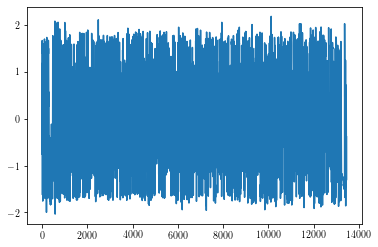

In [27]:
plt.plot(x)

In [28]:
kf = KalmanFilter(
    transition_matrices=A,
    observation_matrices=C,
    observation_offsets=d,
    transition_offsets=np.zeros(4),
    transition_covariance=W,
    observation_covariance=Q
)

In [29]:
means, _ = kf.filter(Z_test)

In [30]:
for idx in range(4):
    print(r2_score(X_test[:, idx], means[:, idx]))
    
print('---')

for idx in range(4):
    print(np.corrcoef(X_test[:, idx], means[:, idx])[0, 1])

0.3369383514077072
0.6689493604909731
0.34219635116807656
0.4383798330755838
---
0.7003730535866213
0.8275570320092539
0.645832255777117
0.7056880133408322


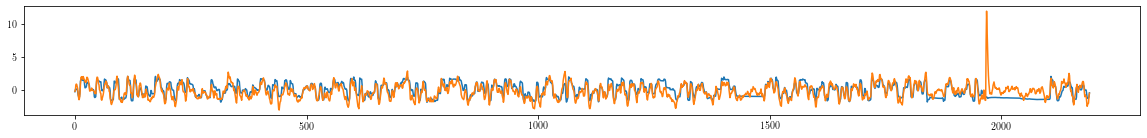

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(20, 2))
plt.plot(X_test[500:, 0])
plt.plot(means[500:, 0])

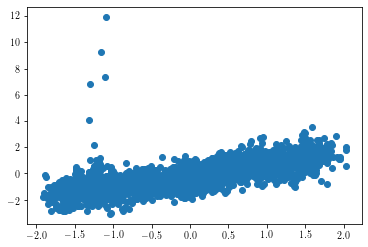

In [37]:
plt.scatter(X_test[:, 0], means[:, 0])

In [100]:
positions = nhp.get_binned_positions(bin_width=dt)


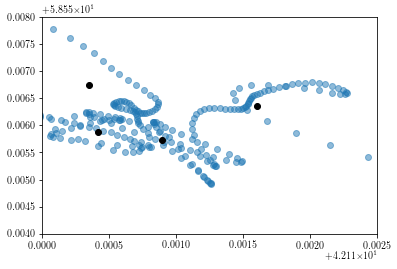

In [105]:
plt.scatter(nhp.cursor_pos[0, :300], nhp.cursor_pos[1, :300], alpha=0.5)
plt.xlim([42.1100, 42.1125])
plt.ylim([58.554, 58.558])
plt.scatter(positions[0:5, 0], positions[0:5, 1], color='k')

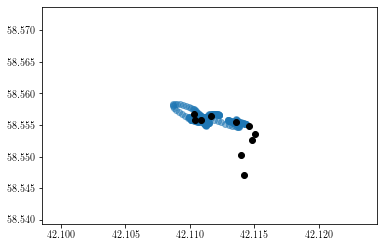

In [108]:
plt.scatter(nhp.cursor_pos[0, :300], nhp.cursor_pos[1, :300], alpha=0.5)
plt.scatter(positions[0:10, 0], positions[0:10, 1], color='k')

In [99]:
positions[0, 0], positions[0, 1]

(1.5674463857344125, 58.555722665328645)

In [97]:
positions[0, 1]

58.555722665328645

In [91]:
positions

array([[ 42.11089764,  -0.19097404],
       [ 42.11035281,  -0.19093432],
       [ 42.11041679,  -0.19096836],
       ...,
       [-23.9870588 ,  -1.26046735],
       [-23.45124504,  -1.24832124],
       [-23.47945034,  -1.23553373]])

In [93]:
nhp.finger_pos.shape

(3, 204446)

In [94]:
nhp.timestamps[:300] - nhp.timestamps[0]

array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
       0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
       0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
       0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
       0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176,
       0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  , 0.204, 0.208, 0.212,
       0.216, 0.22 , 0.224, 0.228, 0.232, 0.236, 0.24 , 0.244, 0.248,
       0.252, 0.256, 0.26 , 0.264, 0.268, 0.272, 0.276, 0.28 , 0.284,
       0.288, 0.292, 0.296, 0.3  , 0.304, 0.308, 0.312, 0.316, 0.32 ,
       0.324, 0.328, 0.332, 0.336, 0.34 , 0.344, 0.348, 0.352, 0.356,
       0.36 , 0.364, 0.368, 0.372, 0.376, 0.38 , 0.384, 0.388, 0.392,
       0.396, 0.4  , 0.404, 0.408, 0.412, 0.416, 0.42 , 0.424, 0.428,
       0.432, 0.436, 0.44 , 0.444, 0.448, 0.452, 0.456, 0.46 , 0.464,
       0.468, 0.472, 0.476, 0.48 , 0.484, 0.488, 0.492, 0.496, 0.5  ,
       0.504, 0.508,

In [96]:
nhp.get_binned_positions(bin_width=dt)

array([[ 42.11089764,  58.55572267],
       [ 42.11035281,  58.55674921],
       [ 42.11041679,  58.55586938],
       ...,
       [-23.9870588 ,  30.91666148],
       [-23.45124504,  31.23055516],
       [-23.47945034,  31.5610244 ]])

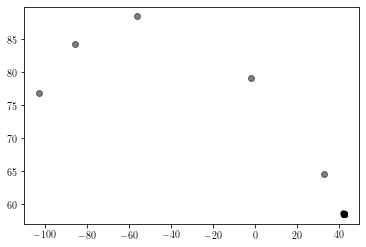

In [112]:
plt.scatter(positions[0:20, 0], positions[0:20, 1], color='k', alpha=0.5)

In [110]:
positions[0:20, 0]

array([  42.11089764,   42.11035281,   42.11041679,   42.11160621,
         42.11357207,   42.11457136,   42.11502666,   42.11480358,
         42.11396187,   42.11419372,   42.11423161,   42.11480928,
         42.11563457,   42.11705907,   41.96949859,   32.67069079,
         -1.98181621,  -56.08780169,  -85.58013895, -102.57692743])

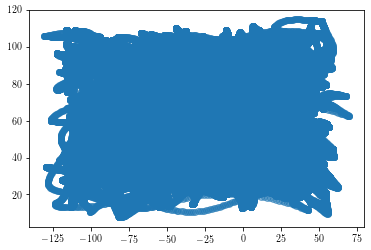

In [111]:
plt.scatter(nhp.cursor_pos[0], nhp.cursor_pos[1], alpha=0.5)
